In [1]:
import os
import math
import config
import random
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import (
    create_img_grid,
    create_img_stack,
    extract_flxion_features,
    SpatialProjection
)

from model import ProjectionNet

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2022-06-23 03:56:34.521903: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data_dir = "../../data/dataset/raw/"
subjects = os.listdir(data_dir)

augmentation_levels = [0, 9, 7, 11, 13]
sp_augment = [
    SpatialProjection(
    img_dir="../../data/dataset/images/",
    # img_len=math.floor(config.IMG_LEN / 3),
    img_len=config.IMG_LEN,
    polyfit_degree=degree
)
    for degree in augmentation_levels ]

test_subject = "007"


In [3]:
train_features = []
train_images = []
train_labels = []
test_features = []
test_images = []
test_labels = []

for subject in tqdm(subjects):
    for gesture in config.GESTURES:
        gesture_dir = os.path.join(data_dir, subject, gesture)
        recordings = os.listdir(gesture_dir)
        for recording in recordings:
            file_path = os.path.join(gesture_dir, recording)

            data = pd.read_csv(file_path)
            data.drop(columns=["time"], inplace=True)
            data.drop(0, inplace=True)  # Remove first All-0 row

            if data.shape[0] == 0:
                continue

            # ... Flag for determining Trainning and Testing Samples
            for_training = random.randint(1, 100) <= 80

            for sp in sp_augment:
                _images = []
                for landmark in config.PROJECTION_LANDMARKS:
                    _images.extend(
                        sp.get_projection_images(
                            data=data.filter(regex=landmark),
                            subject=subject,
                            gesture=gesture
                        )
                    )

                _features = extract_flxion_features(data)

                # img = create_img_grid(_images, config.IMG_LEN)
                img = create_img_stack(_images[:3])

                if for_training:
                    train_features.append(_features)
                    train_images.append(img)
                    train_labels.append(config.GESTURES.index(gesture))
                else:
                    test_features.append(_features)
                    test_images.append(img)
                    test_labels.append(config.GESTURES.index(gesture))
                    break

    #             plt.imshow(img)
    #             # plt.savefig("../assets/projection_demo.pdf")
    #             plt.show()

    #         break
    #     break
    # break


100%|██████████| 7/7 [09:34<00:00, 82.06s/it]


In [4]:
train_features = np.array(train_features)
train_features.shape

(4675, 150, 6)

# Stack CNN Config

In [5]:
train_features = np.array(train_features)
train_images = np.array(train_images, dtype="uint8")
test_features = np.array(test_features)
test_images = np.array(test_images, dtype="uint8")

X_train = np.split(train_features, len(config.DIST_FEATURES), axis=-1) + \
    [np.squeeze(img) for img in np.split(train_images, 3, axis=-1)]

X_test = np.split(test_features, len(config.DIST_FEATURES), axis=-1) + \
    [np.squeeze(img) for img in np.split(test_images, 3, axis=-1)]

y_train = np.array(train_labels, dtype="uint8")
y_test = np.array(test_labels, dtype="uint8")

print(X_train[0].shape)
print(X_train[-1].shape)
print(X_test[0].shape)
print(X_test[-1].shape)
print(y_train.shape)
print(y_test.shape)


(4675, 150, 1)
(4675, 160, 160, 3)
(224, 150, 1)
(224, 160, 160, 3)
(4675,)
(224,)


In [6]:
# X = np.array(images, dtype="uint8")
# X = np.expand_dims(X[:, :, :, 0], axis=-1)
# # X = np.repeat(np.expand_dims(X, axis=-1), 3, axis=-1)
# y = np.array(labels, dtype="uint8")

# X_train = np.array(train_images, dtype="uint8")
# X_test = np.array(test_images, dtype="uint8")

# y_train = np.array(train_labels, dtype="uint8")
# y_test = np.array(test_labels, dtype="uint8")

# X_train = np.expand_dims(X_train[:, :, :, 0], axis=-1)
# X_test = np.expand_dims(X_test[:, :, :, 0], axis=-1)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [7]:
save_dir = f"../../data/dataset/processed/{test_subject}/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

joblib.dump(X_train, os.path.join(save_dir, "X_train_stack_11.joblib"))
joblib.dump(y_train, os.path.join(save_dir, "y_train_stcak_11.joblib"))
joblib.dump(X_test, os.path.join(save_dir, "X_test_stack_11.joblib"))
joblib.dump(y_test, os.path.join(save_dir, "y_test_stack_11.joblib"))

['../../data/dataset/processed/007/y_test_stack_11.joblib']

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42
# )


In [9]:
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# base_model = tf.keras.applications.MobileNetV2(
#     input_shape=(config.IMG_LEN, config.IMG_LEN, 3),
#     include_top=False,
#     weights="imagenet"
# )
# base_model.trainable = True
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# prediction_layer = tf.keras.layers.Dense(len(config.GESTURES))

# inputs = tf.keras.Input(shape=(config.IMG_LEN, config.IMG_LEN, 3))
# x = preprocess_input(inputs)
# x = base_model(x, training=True)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.6)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)


In [10]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Rescaling(
#         1/255.0,
#         input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS)
#     ),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
#     tf.keras.layers.MaxPool2D((2, 2)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(config.GESTURES))
# ])


In [11]:
# import config
# from model import ConvMixer

# model = ConvMixer(
#     img_size=config.IMG_LEN,
#     in_channels=1,
#     n_classes=len(config.GESTURES),
#     n_filters=64,
#     depth=3,
#     kernel_size=5,
#     patch_size=2
# ).model()



In [12]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(config.IMG_LEN, config.IMG_LEN, config.N_CHANNELS),
    include_top=False,
    weights="imagenet"
)

model = ProjectionNet(
    img_size=config.IMG_LEN,
    segment_len=config.SEGMENT_LEN,
    n_classes=len(config.GESTURES),
    base_model=base_model
).get_model(
    n_projections=config.N_CHANNELS,
    n_channels=len(config.DIST_FEATURES)
)


2022-06-23 04:06:15.885527: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-23 04:06:15.885550: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Andromeda
2022-06-23 04:06:15.885554: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Andromeda
2022-06-23 04:06:15.885693: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-06-23 04:06:15.885705: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-06-23 04:06:15.885708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-06-23 04:06:15.886187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [14]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=700,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/700
147/147 [==============================] - 72s 455ms/step - loss: 1.8518 - accuracy: 0.4116 - val_loss: 0.9255 - val_accuracy: 0.7991
Epoch 2/700
147/147 [==============================] - 66s 452ms/step - loss: 0.6977 - accuracy: 0.7805 - val_loss: 0.4131 - val_accuracy: 0.8795
Epoch 3/700
147/147 [==============================] - 66s 448ms/step - loss: 0.4545 - accuracy: 0.8567 - val_loss: 0.3241 - val_accuracy: 0.9241
Epoch 4/700
147/147 [==============================] - 66s 449ms/step - loss: 0.3760 - accuracy: 0.8809 - val_loss: 0.3215 - val_accuracy: 0.9286
Epoch 5/700
147/147 [==============================] - 66s 450ms/step - loss: 0.3232 - accuracy: 0.8935 - val_loss: 0.2713 - val_accuracy: 0.9286
Epoch 6/700
147/147 [==============================] - 66s 452ms/step - loss: 0.2770 - accuracy: 0.9052 - val_loss: 0.2932 - val_accuracy: 0.9196
Epoch 7/700
147/147 [==============================] - 66s 449ms/step - loss: 0.2601 - accuracy: 0.9153 - val_loss: 0.2787 -

In [15]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 3s 414ms/step - loss: 0.2258 - accuracy: 0.9643


[0.22576606273651123, 0.9642857313156128]

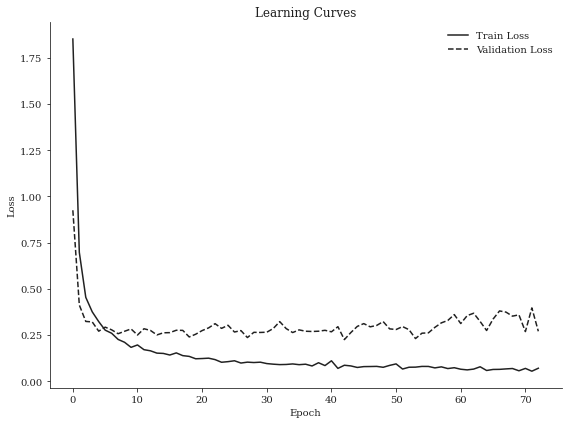

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 22,
    "text.color": "#212121",
    "axes.edgecolor": "#212121",
    "xtick.color": "#212121",
    "ytick.color": "#212121",
    "axes.labelcolor": "#212121",
    'legend.frameon': False,
})

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.plot(history.history["loss"], "-", color="#212121", label="Train Loss")
ax.plot(history.history["val_loss"], "--",
        color="#212121", label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Learning Curves")
plt.legend()
plt.tight_layout()
plt.savefig("../assets/lc.png")
plt.show()


In [17]:
# tf.keras.backend.clear_session()
